# Physics 256
## Physics of Baseball

<img src="https://upload.wikimedia.org/wikipedia/commons/0/01/Fenway_from_Legend%27s_Box.jpg" width=600px>

## Last Time

- projectile motion for a cannon shell with air resistance
- building a simple targetting algorithm

## Today

- 3D motion of a pitched baseball

## Setting up the Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('notebook');
%config InlineBackend.figure_format = 'retina'

## Converting Units

In [10]:
import scipy.constants as constants
def convert(value,unit1,unit2):
    '''Convert value in unit1 to unit2'''
        
    # the converter
    conv = {'ft->m':constants.foot,'in->m':constants.inch,'mph->m/s':constants.mph}

    # make a copy and perform reverse conversions
    cpy_conv = dict(conv)
    for key, val in cpy_conv.items():
        units = key.split('->')
        conv[units[-1]+'->'+units[0]] = 1.0/val
        
    # perform the conversion
    key = '%s->%s'%(unit1,unit2)
    if key in conv:
        return value*conv[key]
    else:
        print('Unit conversion %s not possible.' %key)

## Drag Coefficient of a Baseball

The empirical form (from wind-tunnel and simulation measurements) is given by:

\begin{equation}
\frac{C\rho A}{m} \equiv \frac{B_2}{m} = 0.0039 + \frac{0.0058}{1+\exp{[(v-v_d)/\Delta}]}
\end{equation}

where $v_c \simeq 35~{\rm m/s}$ and $\Delta \simeq 5~{\rm m/s}$.

In [7]:
def B2om(v):
    '''The drag Coefficient of a baseball.
       v in m/s
    '''
    vd = 35.0 # m/s
    Delta = 5.0 # m/s
    return 0.0039 + 0.0058/(1.0 + np.exp((v-vd)/Delta))

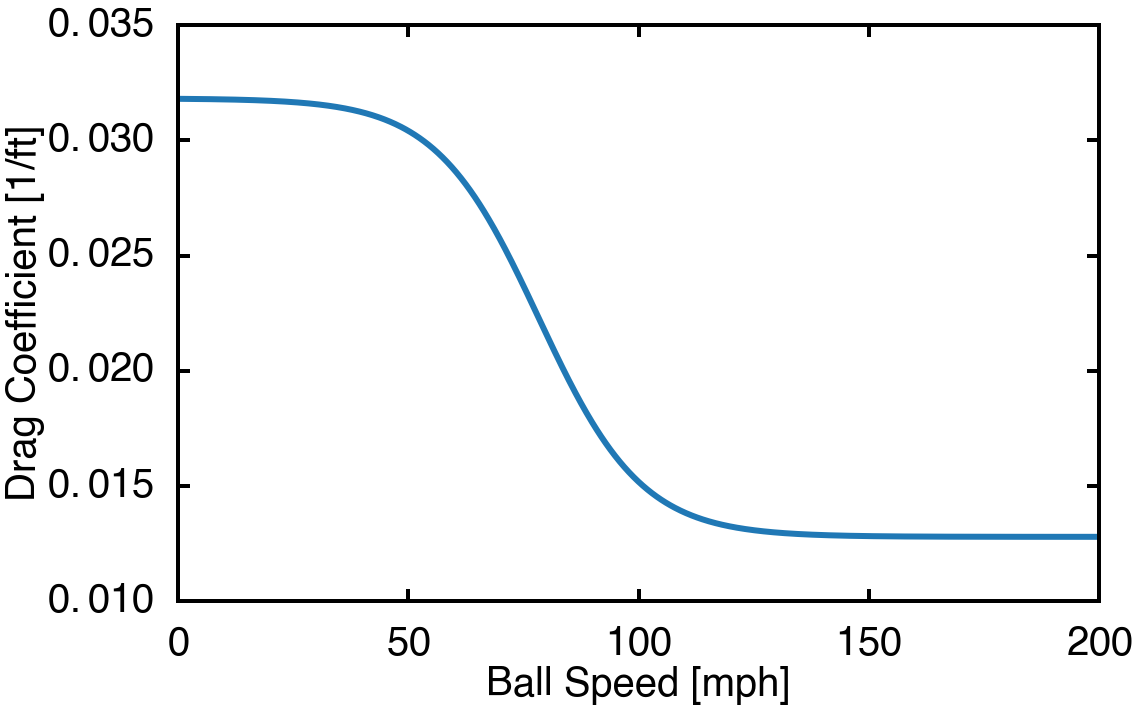

In [11]:
v = np.linspace(0,200,1000)
plt.plot(v,B2om(convert(v,'mph','m/s'))*convert(1.0,'m','ft'))
plt.xlabel('Ball Speed [mph]')
plt.ylabel('Drag Coefficient [1/ft]')

## Equation of Motion for a Spinning Baseball

Taking our coordinate system origin at the pitching rubber with $x$ pointing towards home plate, $y$ pointing up and $z$ towards third base, the total force on a spinning ball is given by:

\begin{equation}
\vec{F} = \vec{F}_{\rm g} + \vec{F}_{\rm drag} + \vec{F}_{\rm magnus}.
\end{equation}

where the Magnus force is:

\begin{equation}
\vec{F}_{\rm magnus} = S_0 \vec{\omega} \times \vec{v}
\end{equation}

with the direction of $\vec{\omega}$ determined by the right-hand-rule and $S_0$ is related to the solid angular average of the drage coefficient $C$.

This can be decomposed into the following 3D equation of motion:
\begin{align}
\frac{d v_x}{dt} &= -\frac{B_2}{m} v v_x \\
\frac{d v_y}{dt} &= -g \\
\frac{d v_z}{dt} &= - \frac{S_0}{m} \omega v_x
\end{align}

which can be iterated using the Euler method to find the trajectory of the ball.

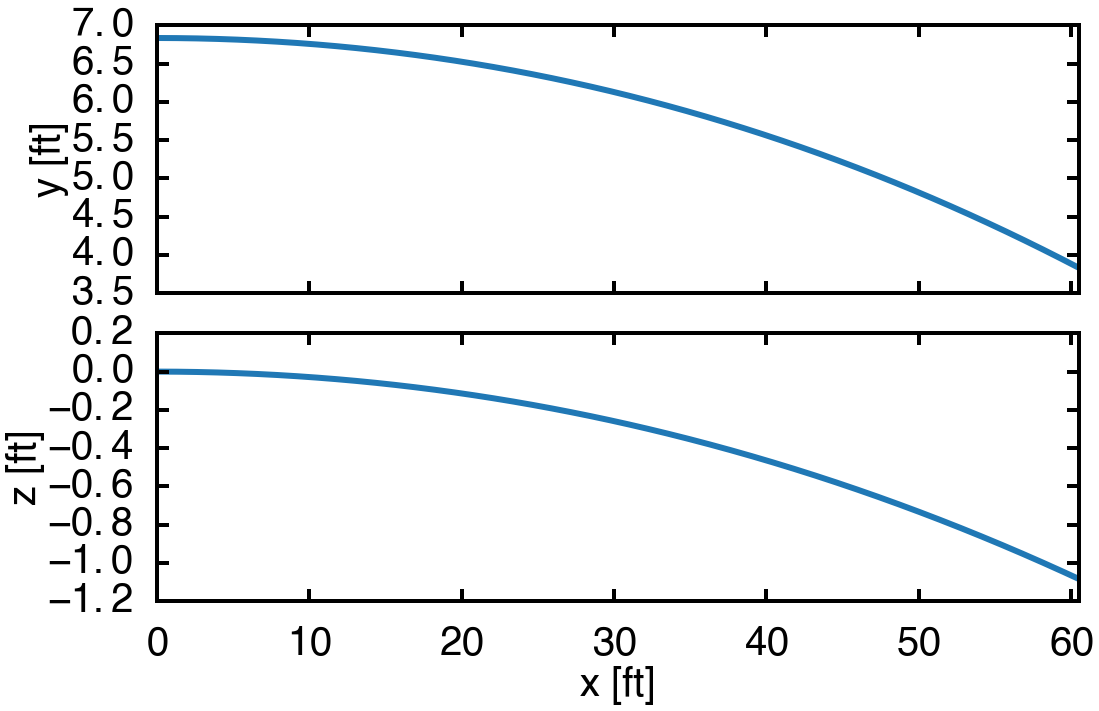

In [12]:
from scipy.constants import g,pi
π = pi

# the time step
Δt = 0.001 # s

# the dimensionless angular drag factor
S0om = 4.1E-4

# the angular velocity
ω = 1900 * 2*π / 60 # rad/s

# initial conditions (convert everything to SI)
vx,vy,vz = convert(100,'mph','m/s'),0.0,0.0
r = np.array([[0.0,convert(6.0+10.0/12.0,'ft','m'),0.0]])
while r[-1,0] <= convert(60.5,'ft','m'):
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    vx -= B2om(v)*v*vx*Δt
    vy -= g*Δt
    vz -= S0om*vx*ω*Δt
    cr = np.array([[vx,vy,vz]])*Δt
    r = np.append(r,r[-1]+cr,axis=0)            

# convert the result to feet
r = convert(r,'m','ft')

# Plot the resulting trajectory
f, ax = plt.subplots(2, sharex=True)

# the x-y plane
ax[0].plot(r[:,0],r[:,1])
ax[0].set_ylabel('y [ft]')

# the y-z plane
ax[1].plot(r[:,0],r[:,2])
ax[1].set_ylabel('z [ft]')
ax[1].set_xlabel('x [ft]')
ax[1].set_xlim(0,60.5);

## The Knuckleball

In [ ]:
def Fknuck(θ):
    '''The lateral acceleration on a knucleball in m/s^2'''
    from scipy.constants import g
    Fom = 0.5*g*(np.sin(4.0*θ) - 0.25*np.sin(8.0*θ) + \
                0.08*np.sin(12.0*θ) - 0.025*np.sin(16.0*θ))
    return Fom

In [ ]:
θ = np.linspace(0,2*π,1000)
plt.plot(θ,Fknuck(θ))
plt.xlim(0,2*π);
plt.xlabel('θ [rad]')
plt.ylabel(r'$F/m\ [{\rm m/s^2}]$')